# Example 13 - Three Point Problem

This example will show how to convert the geological map below using ``GemGIS`` to a `GemPy` model. This example is based on digitized data. The area is 2991 m wide (W-E extent) and 3736 m high (N-S extent). This example represents a classic "three-point-problem" of a planar dipping layer. THe interface points were not taken at the surface but rather in boreholes

The map has been georeferenced with QGIS. The outcrops of the layers were digitized in QGIS. The contour lines were also digitized and will be interpolated with `GemGIS` to create a topography for the model. 

<img src="../images/cover_example13.png" width="800">

Map Source: An Introduction to Geological Structures and Maps by G.M. Bennison

## Import GemGIS

If you have installed ``GemGIS`` via pip, you can import ``GemGIS`` like any other package. If you have downloaded the repository, append the path to the directory where the ``GemGIS`` repository is stored and then import ``GemGIS``. 

In [1]:
import warnings
warnings.filterwarnings("ignore")
import gemgis as gg

## Importing Libraries and loading Data

All remaining packages can be loaded in order to prepare the data and to construct the model. The example data is downloaded from an external server using `pooch`. It will be stored in a data folder in the same directory where this notebook is stored.  

In [2]:
import geopandas as gpd
import rasterio 

In [3]:
file_path = 'data/example13/'
gg.download_gemgis_data.download_tutorial_data(filename="example13_three_point_problem.zip", dirpath=file_path)

## Creating Digital Elevation Model from Contour Lines

The digital elevation model (DEM) will be created by interpolating contour lines digitized from the georeferenced map using the `SciPy` Radial Basis Function interpolation wrapped in `GemGIS`. The respective function used for that is `gg.vector.interpolate_raster()`. 

<img src="../images/dem_example13.png" width="800">

In [4]:
topo = gpd.read_file(file_path + 'topo13.shp')
topo.head()

,id,Z,geometry
0,None,800,"LINESTRING (1.482 1748.098, 50.293 1669.250, 9..."
1,None,900,"LINESTRING (2.060 3333.723, 69.355 3237.834, 1..."
2,None,1000,"LINESTRING (681.366 917.450, 738.552 907.053, ..."
3,None,1000,"LINESTRING (36.141 3724.208, 57.225 3659.223, ..."
4,None,1100,"LINESTRING (249.868 3718.720, 252.467 3636.407..."


### Interpolating the contour lines

In [5]:
topo_raster = gg.vector.interpolate_raster(gdf=topo, value='Z', method='rbf', res=10)

### Plotting the raster

Text(115.04108047488316, 0.5, 'Y [m]')

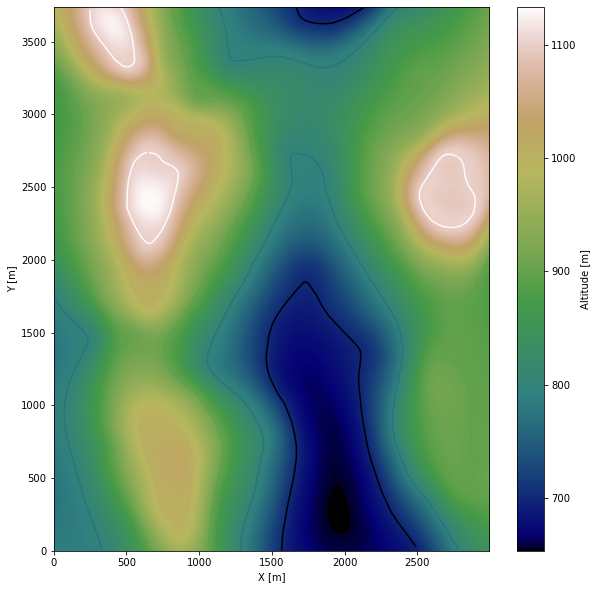

In [6]:
import matplotlib.pyplot as plt

fix, ax = plt.subplots(1, figsize=(10,10))
topo.plot(ax=ax, aspect='equal', column='Z', cmap='gist_earth')
im = plt.imshow(topo_raster, origin='lower', extent=[0,2991,0,3736], cmap='gist_earth')
cbar = plt.colorbar(im)
cbar.set_label('Altitude [m]')
plt.xlabel('X [m]')
plt.ylabel('Y [m]')

### Saving the raster to disc

After the interpolation of the contour lines, the raster is saved to disc using `gg.raster.save_as_tiff()`. The function will not be executed as a raster is already provided with the example data. 

### Opening Raster

The previously computed and saved raster can now be opened using rasterio. 

In [7]:
topo_raster = rasterio.open(file_path + 'raster13.tif')

## Interface Points of stratigraphic boundaries

The interface points for this three point example will be digitized as points with the respective height value as given by the contour lines and the respective formation.  

<img src="../images/interfaces_example13.png" width="800">

In [8]:
interfaces = gpd.read_file(file_path + 'interfaces13.shp')
interfaces.head()

,id,formation,Z,geometry
0,None,Coal1,950,POINT (366.363 2287.350)
1,None,Coal2,550,POINT (366.363 2287.350)
2,None,Coal2,650,POINT (1822.758 2645.532)
3,None,Coal2,450,POINT (2110.811 1006.118)
4,None,Coal1,1050,POINT (1822.758 2645.532)


### Extracting Z coordinate from Digital Elevation Model

In [9]:
interfaces_coords = gg.vector.extract_xyz(gdf=interfaces, dem=None)
interfaces_coords

,formation,Z,geometry,X,Y
0,Coal1,950.00,POINT (366.363 2287.350),366.36,2287.35
1,Coal2,550.00,POINT (366.363 2287.350),366.36,2287.35
2,Coal2,650.00,POINT (1822.758 2645.532),1822.76,2645.53
3,Coal2,450.00,POINT (2110.811 1006.118),2110.81,1006.12
4,Coal1,1050.00,POINT (1822.758 2645.532),1822.76,2645.53
5,Coal1,850.00,POINT (2110.811 1006.118),2110.81,1006.12


### Plotting the Interface Points

Text(53.5, 0.5, 'Y [m]')

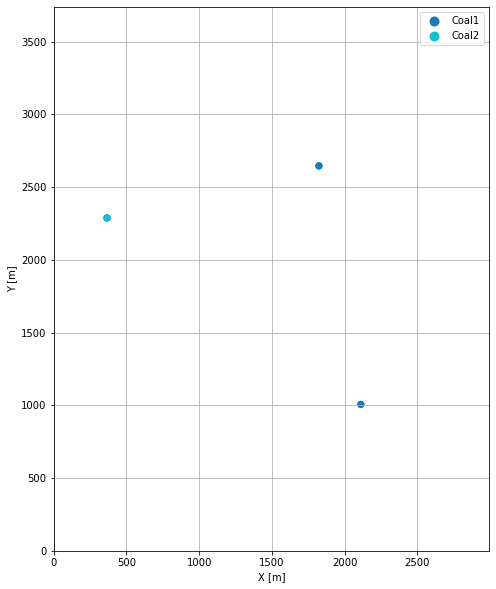

In [10]:
fig, ax = plt.subplots(1, figsize=(10,10))

interfaces.plot(ax=ax, column='formation', legend=True, aspect='equal')
interfaces_coords.plot(ax=ax, column='formation', legend=True, aspect='equal')
plt.grid()
plt.xlim(0,2991)
plt.ylim(0,3736)
plt.xlabel('X [m]')
plt.ylabel('Y [m]')

## Orientations from Strike Lines

For this three point example, an orientation is calculated using `gg.vector.calculate_orientation_for_three_point_problem()`. 

<img src="../images/orientations_example13.png" width="800">

In [11]:
import pandas as pd
orientations1 = gg.vector.calculate_orientation_for_three_point_problem(gdf=interfaces[interfaces['formation'] == 'Coal1'])
orientations2 = gg.vector.calculate_orientation_for_three_point_problem(gdf=interfaces[interfaces['formation'] == 'Coal2'])
orientations = pd.concat([orientations1, orientations2]).reset_index()
orientations

,index,Z,formation,azimuth,dip,polarity,X,Y,geometry
0,0,950.0,Coal1,16.09,172.38,1,1433.31,1979.67,POINT (1433.311 1979.667)
1,0,550.0,Coal2,16.09,172.38,1,1433.31,1979.67,POINT (1433.311 1979.667)


In [12]:
orientations['Z'] = orientations['Z'].astype(float)
orientations['azimuth'] = orientations['azimuth'].astype(float)
orientations['dip'] = orientations['dip'].astype(float)
orientations['dip'] = 180 - orientations['dip']
orientations['azimuth'] = 180 - orientations['azimuth']
orientations['polarity'] = orientations['polarity'].astype(float)
orientations['X'] = orientations['X'].astype(float)
orientations['Y'] = orientations['Y'].astype(float)
orientations.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   index      2 non-null      int64   
 1   Z          2 non-null      float64 
 2   formation  2 non-null      object  
 3   azimuth    2 non-null      float64 
 4   dip        2 non-null      float64 
 5   polarity   2 non-null      float64 
 6   X          2 non-null      float64 
 7   Y          2 non-null      float64 
 8   geometry   2 non-null      geometry
dtypes: float64(6), geometry(1), int64(1), object(1)
memory usage: 272.0+ bytes


In [13]:
orientations

,index,Z,formation,azimuth,dip,polarity,X,Y,geometry
0,0,950.00,Coal1,163.91,7.62,1.00,1433.31,1979.67,POINT (1433.311 1979.667)
1,0,550.00,Coal2,163.91,7.62,1.00,1433.31,1979.67,POINT (1433.311 1979.667)


### Plotting the Orientations

Text(53.5, 0.5, 'Y [m]')

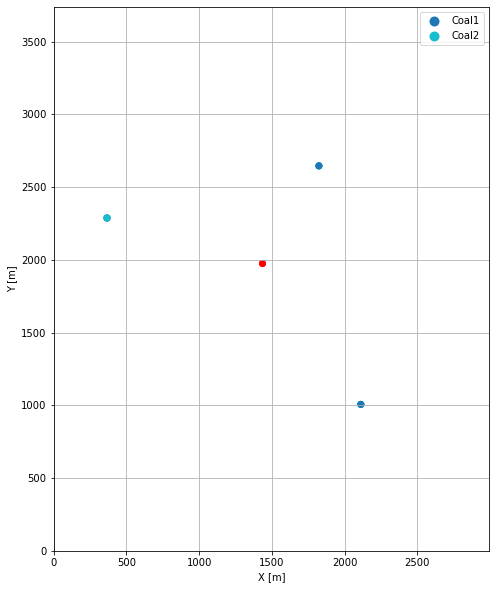

In [14]:
fig, ax = plt.subplots(1, figsize=(10,10))

interfaces.plot(ax=ax, column='formation', legend=True, aspect='equal')
interfaces_coords.plot(ax=ax, column='formation', legend=True, aspect='equal')
orientations.plot(ax=ax, color='red', aspect='equal')
plt.grid()
plt.xlim(0,2991)
plt.ylim(0,3736)
plt.xlabel('X [m]')
plt.ylabel('Y [m]')

## GemPy Model Construction

The structural geological model will be constructed using the `GemPy` package. 

In [15]:
import gempy as gp

WARNING (theano.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


### Creating new Model

In [16]:
geo_model = gp.create_model('Model13')
geo_model

Model13  2021-03-31 09:15

### Initiate Data

In [17]:
gp.init_data(geo_model, [0,2991,0,3736,250,1200], [100,100,100],
             surface_points_df = interfaces_coords[interfaces_coords['Z']!=0],
             orientations_df = orientations,
             default_values=True)

Active grids: ['regular']


Model13  2021-03-31 09:15

### Model Surfaces

In [18]:
geo_model.surfaces

,surface,series,order_surfaces,color,id
0,Coal1,Default series,1,#015482,1
1,Coal2,Default series,2,#9f0052,2


### Mapping the Stack to Surfaces

In [19]:
gp.map_stack_to_surfaces(geo_model,
                         {
                          'Strata1': ('Coal1', 'Coal2'),
                         },
                         remove_unused_series=True)
geo_model.add_surfaces('Basement')

,surface,series,order_surfaces,color,id
0,Coal1,Strata1,1,#015482,1
1,Coal2,Strata1,2,#9f0052,2
2,Basement,Strata1,3,#ffbe00,3


### Showing the Number of Data Points

In [20]:
gg.utils.show_number_of_data_points(geo_model=geo_model)

,surface,series,order_surfaces,color,id,No. of Interfaces,No. of Orientations
0,Coal1,Strata1,1,#015482,1,3,1
1,Coal2,Strata1,2,#9f0052,2,3,1
2,Basement,Strata1,3,#ffbe00,3,0,0


### Loading Digital Elevation Model

In [21]:
geo_model.set_topography(
    source='gdal', filepath=file_path + 'raster13.tif')

Cropped raster to geo_model.grid.extent.
depending on the size of the raster, this can take a while...
storing converted file...
Active grids: ['regular' 'topography']


Grid Object. Values: 
array([[  14.955     ,   18.68      ,  254.75      ],
       [  14.955     ,   18.68      ,  264.25      ],
       [  14.955     ,   18.68      ,  273.75      ],
       ...,
       [2985.99832776, 3711.02673797,  907.33477783],
       [2985.99832776, 3721.01604278,  906.7131958 ],
       [2985.99832776, 3731.00534759,  906.11096191]])

### Plotting Input Data

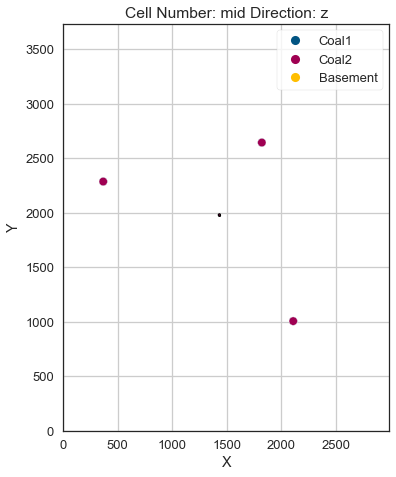

In [22]:
gp.plot_2d(geo_model, direction='z', show_lith=False, show_boundaries=False)
plt.grid()

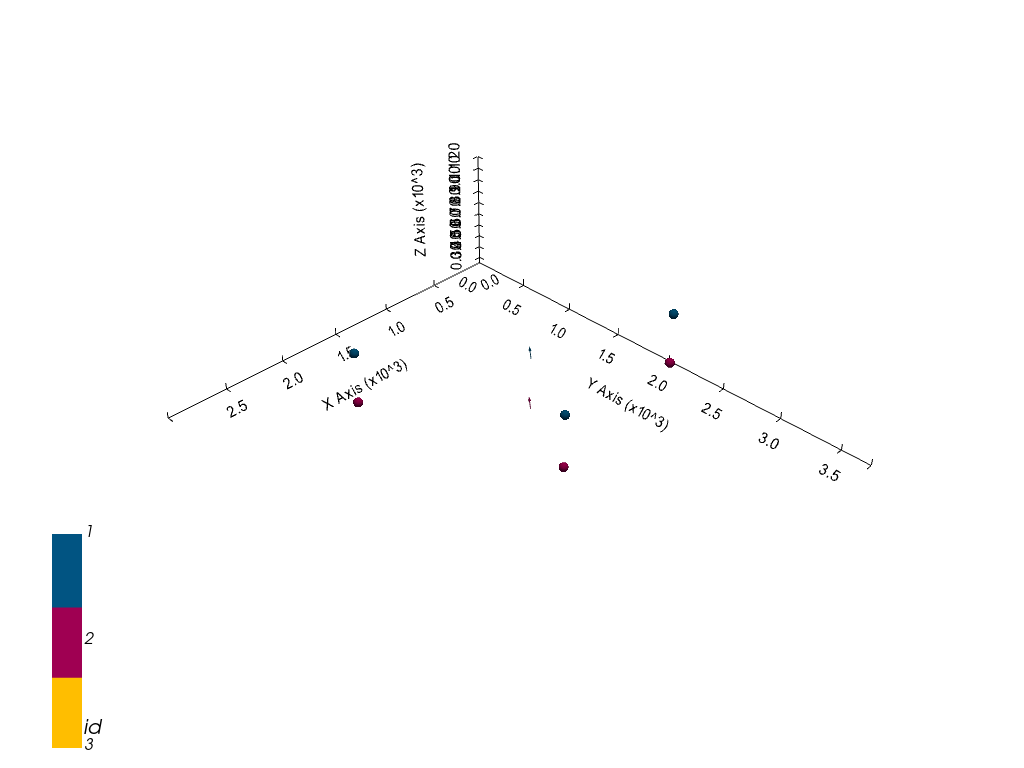

In [23]:
gp.plot_3d(geo_model, image=False, plotter_type='basic', notebook=True)

### Setting the Interpolator

In [24]:
gp.set_interpolator(geo_model,
                    compile_theano=True,
                    theano_optimizer='fast_compile',
                    verbose=[],
                    update_kriging = False
                    )

Compiling theano function...
Level of Optimization:  fast_compile
Device:  cpu
Precision:  float64
Number of faults:  0
Compilation Done!
Kriging values: 
                    values
range             4879.17
$C_o$           566816.12
drift equations       [3]


### Computing Model

In [25]:
sol = gp.compute_model(geo_model, compute_mesh=True)

### Plotting Cross Sections

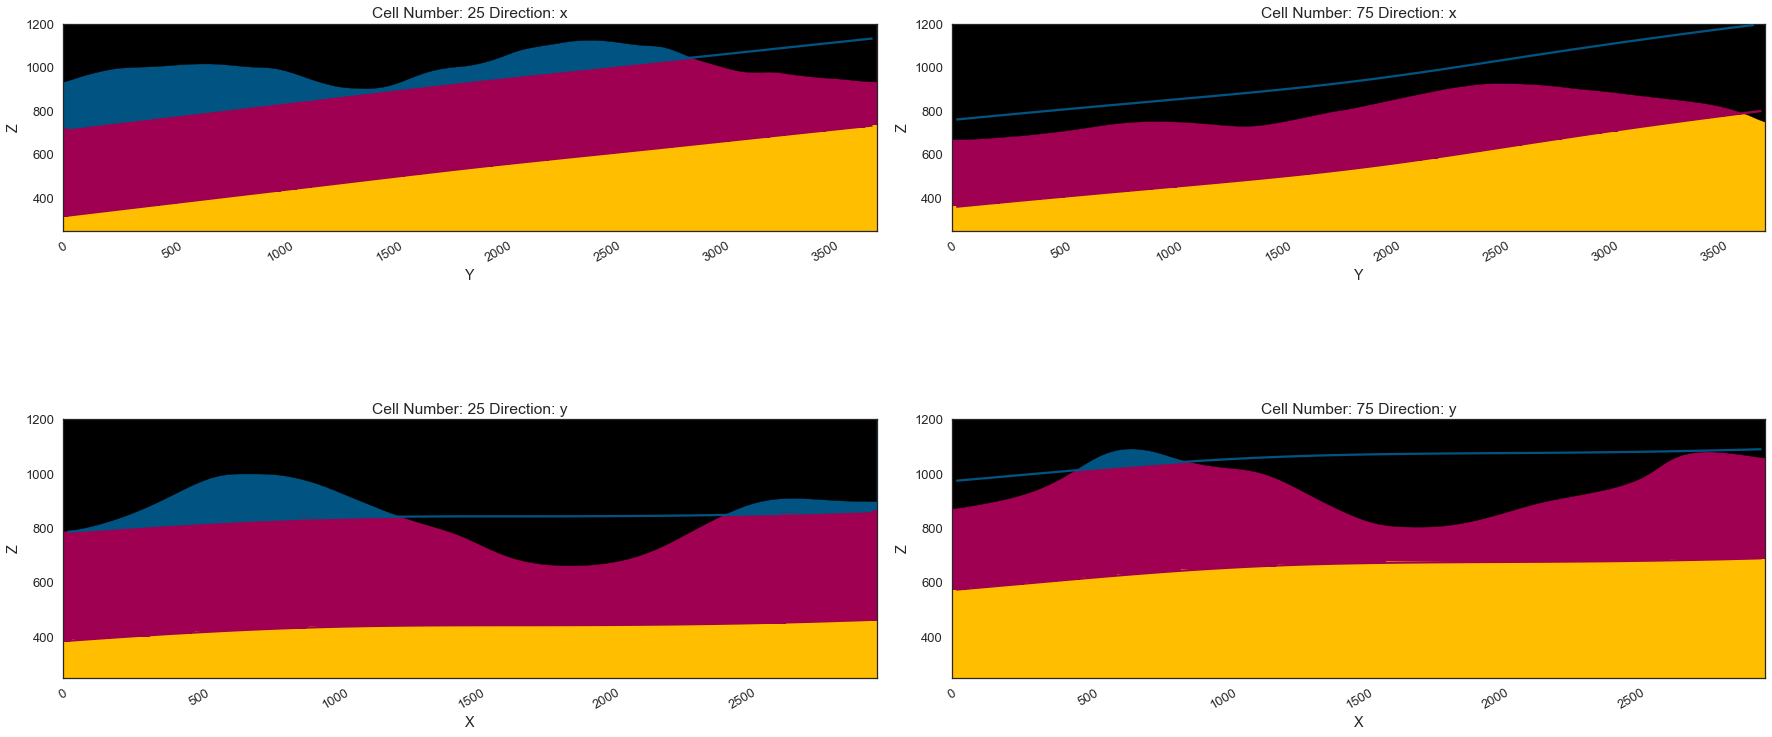

In [26]:
gp.plot_2d(geo_model, direction=['x', 'x', 'y', 'y'], cell_number=[25,75,25,75], show_topography=True, show_data=False)

### Plotting 3D Model

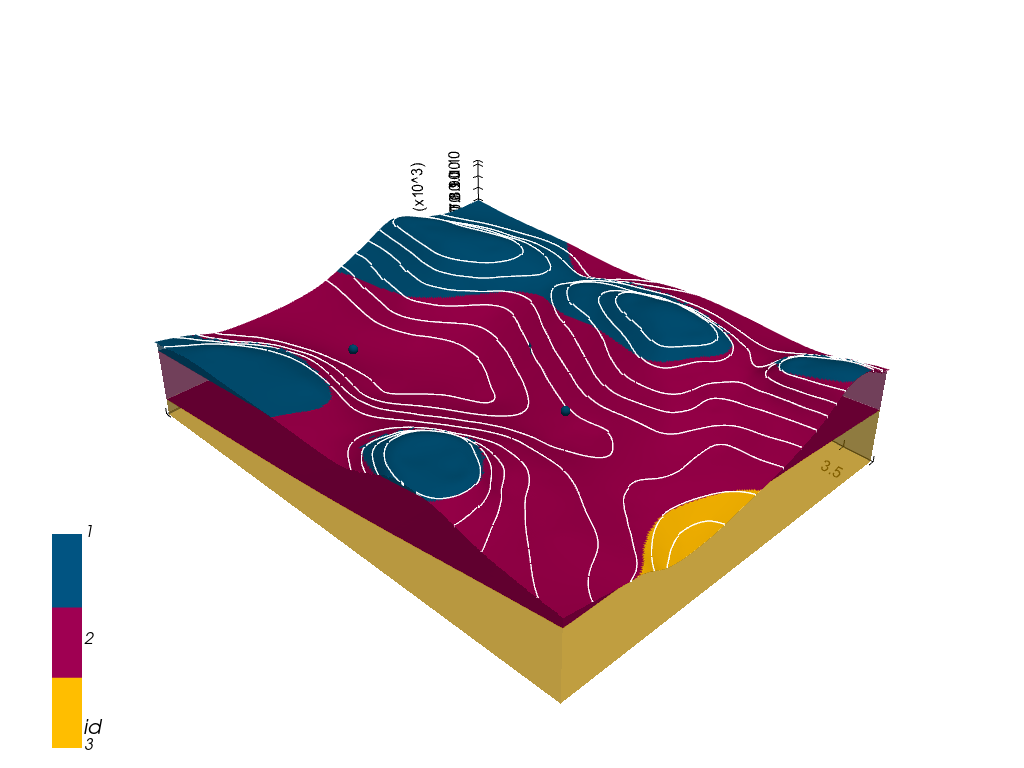

In [27]:
gpv = gp.plot_3d(geo_model, image=False, show_topography=True,
                 plotter_type='basic', notebook=True, show_lith=True)